# Gets summary statistics of all the results gotten so far

- Mean target value selected
- Min target value selected
- Time until minimum selected

In [6]:
import os
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [86]:
def load_results(base_path, regex):
    results = []
    for filename in os.listdir(base_path):
        if bool(re.match(regex, filename)):
            with open(os.path.join(base_path, filename), "rb") as file:
                results.append(pickle.load(file))
    return results


# Function to compute statistics across runs
def aggregate_results(results, key):
    all_data = [res[key] for res in results if key in res]
    mean_data = np.mean(all_data, axis=0)
    std_dev_data = np.std(all_data, axis=0)
    return mean_data, std_dev_data

def plot_everything(
    base_path,
    experiment,
    num_cbo_graphs,
    n_obs=200,
    n_int=2,
    noiseless=True,
    save_file=False,
    plot_ceo=True,
    plot_cbo=True,
    plot_bo=True,
    graph_idxs=None,
):
    if graph_idxs is None:
        graph_idxs = range(num_cbo_graphs)
    # Determine the string suffix based on the noiseless flag
    noisy_suffix = r"\.pickle" if noiseless else r"noisy\.pickle"
    noisy_string = "" if noiseless else "_noisy"

    # Load and aggregate results for CEO
    ceo_string = rf".*_ceo_.*_results_{n_obs}_{n_int}_{noisy_suffix}"
    ceo_results = load_results(base_path, ceo_string)
    ceo_mean, ceo_std = aggregate_results(ceo_results, experiment)

    # Load and aggregate results for BO
    # Load and aggregate results for CEO
    bo_string = rf".*_bo_results_{n_obs}_{n_int}_{noisy_suffix}"
    bo_results = load_results(base_path, bo_string)
    bo_mean, bo_std = aggregate_results(bo_results, experiment)

    # Initialize plot for CEO results
    if plot_ceo:
        x_values = range(len(ceo_mean))
        plt.fill_between(x_values, ceo_mean - ceo_std, ceo_mean + ceo_std, alpha=0.2)
        plt.plot(x_values, ceo_mean, label="CEO Mean")

    if plot_bo:
        x_values = range(len(bo_mean))
        plt.fill_between(x_values, bo_mean - bo_std, bo_mean + bo_std, alpha=0.2)
        plt.plot(x_values, bo_mean, label="BO Mean")

    # Process each CBO graph dynamically
    for graph_index in range(num_cbo_graphs):
        cbo_string = (
            rf".*_cbo_results_{n_obs}_{n_int}_graph_{graph_index}{noisy_suffix}"
        )
        cbo_results = load_results(base_path, cbo_string)
        cbo_mean, cbo_std = aggregate_results(cbo_results, experiment)

        # Plotting results for each CBO graph
        if graph_index in graph_idxs:
            x_values = range(len(cbo_mean))
            plt.fill_between(
                x_values, cbo_mean - cbo_std, cbo_mean + cbo_std, alpha=0.2
            )
            plt.plot(x_values, cbo_mean, label=f"CBO Graph {graph_index}")

    # Final plot adjustments
    plt.xlabel("Trial")
    plt.ylabel("Y value")
    plt.legend()

    if save_file:
        filename = f"{base_path}/{experiment}_{n_obs}_{n_int}_{noisy_string}"
        plt.savefig(filename)

    plt.show()


def all_means(
    base_path,
    num_cbo_graphs,
    n_obs=200,
    n_int=2,
    noiseless=True,
    graph_idxs=None):

    if graph_idxs is None:
        graph_idxs = range(num_cbo_graphs)

    mean_results = {}
    noisy_suffix = r"\.pickle" if noiseless else r"noisy\.pickle"
    noisy_string = "" if noiseless else "_noisy"

    # Load and aggregate results for CEO
    ceo_string = rf".*_ceo_.*_results_{n_obs}_{n_int}_{noisy_suffix}"
    ceo_results = load_results(base_path, ceo_string)
    ceo_results = np.hstack([ceo_result["Per_trial_Y"] for ceo_result in ceo_results])
    ceo_mean = np.mean(ceo_results)
    ceo_std = np.std(ceo_results)
    mean_results["ceo"] = {"mean": ceo_mean, "std": ceo_std}

    # Load and aggregate results for BO
    # Load and aggregate results for CEO
    bo_string = rf".*_bo_results_{n_obs}_{n_int}_{noisy_suffix}"
    bo_results = load_results(base_path, bo_string)
    bo_results = np.hstack([bo_result["Per_trial_Y"] for bo_result in bo_results])
    bo_mean = np.mean(bo_results)
    bo_std = np.std(bo_results)
    mean_results["bo"] = {"mean": bo_mean, "std": bo_std}

    for graph_index in range(num_cbo_graphs):
        cbo_string = (
            rf".*_cbo_results_{n_obs}_{n_int}_graph_{graph_index}{noisy_suffix}"
        )
        cbo_results = load_results(base_path, cbo_string)
        cbo_results = np.hstack([cbo_result["Per_trial_Y"] for cbo_result in cbo_results])
        cbo_mean = np.mean(cbo_results)
        cbo_std = np.std(cbo_results)
        mean_results[f"cbo_{graph_index}"] = {"mean": cbo_mean, "std": cbo_std}

    return mean_results

def all_best(
    base_path,
    num_cbo_graphs,
    n_obs=200,
    n_int=2,
    noiseless=True,
    graph_idxs=None
    ):
    if graph_idxs is None:
        graph_idxs = range(num_cbo_graphs)

    min_results = {}
    noisy_suffix = r"\.pickle" if noiseless else r"noisy\.pickle"
    noisy_string = "" if noiseless else "_noisy"

    # Load and aggregate results for CEO
    ceo_string = rf".*_ceo_.*_results_{n_obs}_{n_int}_{noisy_suffix}"
    ceo_results = load_results(base_path, ceo_string)
    ceo_results = np.vstack([ceo_result["Best_Y"] for ceo_result in ceo_results])
    ceo_best_results = ceo_results.min(axis=1)
    ceo_mean = np.mean(ceo_best_results)
    ceo_std = np.std(ceo_best_results)
    min_results["ceo"] = {"mean": ceo_mean, "std": ceo_std}

    # Load and aggregate results for BO
    # Load and aggregate results for CEO
    bo_string = rf".*_bo_results_{n_obs}_{n_int}_{noisy_suffix}"
    bo_results = load_results(base_path, bo_string)
    bo_results = np.vstack([bo_result["Best_Y"] for bo_result in bo_results])
    bo_best_results = bo_results.min(axis=1)
    bo_mean = np.mean(bo_best_results)
    bo_std = np.std(bo_best_results)
    min_results["bo"] = {"mean": bo_mean, "std": bo_std}

    for graph_index in range(num_cbo_graphs):
        cbo_string = (
            rf".*_cbo_results_{n_obs}_{n_int}_graph_{graph_index}{noisy_suffix}"
        )
        cbo_results = load_results(base_path, cbo_string)
        cbo_results = np.vstack([cbo_result["Per_trial_Y"] for cbo_result in cbo_results])
        cbo_best_results = cbo_results.min(axis=1)
        cbo_mean = np.mean(cbo_best_results)
        cbo_std = np.std(cbo_best_results)
        min_results[f"cbo_{graph_index}"] = {"mean": cbo_mean, "std": cbo_std}

    return min_results

def all_best(
    base_path,
    num_cbo_graphs,
    n_obs=200,
    n_int=2,
    noiseless=True,
    graph_idxs=None
):

    min_results = {}
    noisy_suffix = r"\.pickle" if noiseless else r"noisy\.pickle"
    noisy_string = "" if noiseless else "_noisy"

    # Load and aggregate results for CEO
    ceo_string = rf".*_ceo_.*_results_{n_obs}_{n_int}_{noisy_suffix}"
    ceo_results = load_results(base_path, ceo_string)
    ceo_results = np.vstack([ceo_result["Best_Y"] for ceo_result in ceo_results])
    ceo_best_results = ceo_results.min(axis=1)
    ceo_mean = np.mean(ceo_best_results)
    ceo_std = np.std(ceo_best_results)
    min_results["ceo"] = {"mean": ceo_mean, "std": ceo_std}

    # Load and aggregate results for BO
    # Load and aggregate results for CEO
    bo_string = rf".*_bo_results_{n_obs}_{n_int}_{noisy_suffix}"
    bo_results = load_results(base_path, bo_string)
    bo_results = np.vstack([bo_result["Best_Y"] for bo_result in bo_results])
    bo_best_results = bo_results.min(axis=1)
    bo_mean = np.mean(bo_best_results)
    bo_std = np.std(bo_best_results)
    min_results["bo"] = {"mean": bo_mean, "std": bo_std}

    for graph_index in range(num_cbo_graphs):
        cbo_string = (
            rf".*_cbo_results_{n_obs}_{n_int}_graph_{graph_index}{noisy_suffix}"
        )
        cbo_results = load_results(base_path, cbo_string)
        cbo_results = np.vstack([cbo_result["Per_trial_Y"] for cbo_result in cbo_results])
        cbo_best_results = cbo_results.min(axis=1)
        cbo_mean = np.mean(cbo_best_results)
        cbo_std = np.std(cbo_best_results)
        min_results[f"cbo_{graph_index}"] = {"mean": cbo_mean, "std": cbo_std}

    return min_results

def iterations_to_min(
    base_path,
    num_cbo_graphs,
    n_obs=100,
    n_int=2,
    noiseless=True,
    graph_idxs=None
):
    argmin_results = {}
    noisy_suffix = r"\.pickle" if noiseless else r"noisy\.pickle"
    noisy_string = "" if noiseless else "_noisy"

    # Load and aggregate results for CEO
    ceo_string = rf".*_ceo_.*_results_{n_obs}_{n_int}_{noisy_suffix}"
    ceo_results = load_results(base_path, ceo_string)
    ceo_results = np.vstack([ceo_result["Best_Y"] for ceo_result in ceo_results])
    ceo_best_results = ceo_results.argmin(axis=1)
    ceo_mean = np.mean(ceo_best_results)
    ceo_std = np.std(ceo_best_results)
    argmin_results["ceo"] = {"mean": ceo_mean, "std": ceo_std}

    # Load and aggregate results for BO
    # Load and aggregate results for CEO
    bo_string = rf".*_bo_results_{n_obs}_{n_int}_{noisy_suffix}"
    bo_results = load_results(base_path, bo_string)
    bo_results = np.vstack([bo_result["Best_Y"] for bo_result in bo_results])
    bo_best_results = bo_results.argmin(axis=1)
    bo_mean = np.mean(bo_best_results)
    bo_std = np.std(bo_best_results)
    argmin_results["bo"] = {"mean": bo_mean, "std": bo_std}

    for graph_index in range(num_cbo_graphs):
        cbo_string = (
            rf".*_cbo_results_{n_obs}_{n_int}_graph_{graph_index}{noisy_suffix}"
        )
        cbo_results = load_results(base_path, cbo_string)
        cbo_results = np.vstack([cbo_result["Per_trial_Y"] for cbo_result in cbo_results])
        cbo_best_results = cbo_results.argmin(axis=1)
        cbo_mean = np.mean(cbo_best_results)
        cbo_std = np.std(cbo_best_results)
        argmin_results[f"cbo_{graph_index}"] = {"mean": cbo_mean, "std": cbo_std}

    return argmin_results

def box_plots_mean(mean_results: dict, experiment: str):
    # Setup the plot
    fig, ax = plt.subplots()
    for i, (key, val) in enumerate(mean_results.items()):
        mean, std = val['mean'], val['std']
        # Create the box
        box = plt.Rectangle((i-0.4, mean-std), 0.8, 2*std, color='lightblue', alpha=0.5)
        ax.add_patch(box)
        # Plot the mean line
        plt.plot([i-0.4, i+0.4], [mean, mean], color='red')

    # Set plot properties
    plt.xticks(range(len(mean_results)), labels=mean_results.keys(), rotation=45)
    plt.ylabel('Value')
    plt.title(f'{experiment} y value for each algorithm')
    plt.grid(True)
    plt.show()


# ToyGraph

{'ceo': {'mean': -0.6963638899219685, 'std': 0.661587419008229}, 'bo': {'mean': -1.8402820512451523, 'std': 0.040712738112416484}, 'cbo_0': {'mean': -1.8157954959793317, 'std': 0.18787581895658176}, 'cbo_1': {'mean': -1.335474608782703, 'std': 0.6755834190424241}, 'cbo_2': {'mean': -1.8298011682364703, 'std': 0.14947782815218602}, 'cbo_3': {'mean': -1.8458994664353774, 'std': 0.11905627093113774}, 'cbo_4': {'mean': -1.847977232426027, 'std': 0.11185831991547834}, 'cbo_5': {'mean': -1.8221205239515792, 'std': 0.16849512430772579}, 'cbo_6': {'mean': -1.4127696210917198, 'std': 0.6516595757959703}}


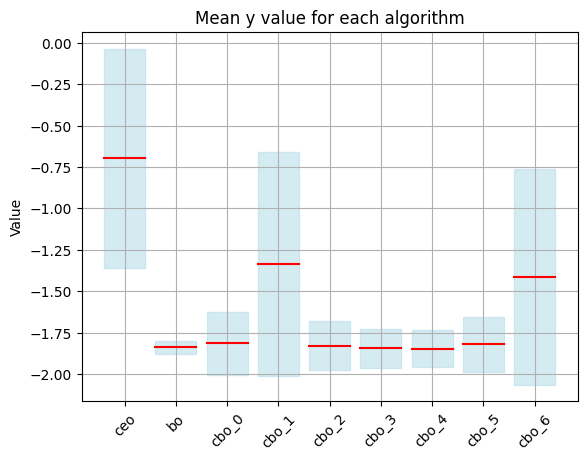

In [87]:
base_path = "ToyGraph"
# plot_everything(base_path=base_path, experiment="Best_Y", n_obs=10, num_cbo_graphs=7,save_file=False, plot_ceo=True, graph_idxs = [0, 4, 6])
mean_results = all_means(base_path=base_path, num_cbo_graphs=7)
print(mean_results)
box_plots_mean(mean_results, experiment="Mean")


{'ceo': {'mean': -2.1077622882716804, 'std': 0.10373938818601597}, 'bo': {'mean': -1.9069116395960357, 'std': 0.016820957800141055}, 'cbo_0': {'mean': -2.0035712491445294, 'std': 0.13356860289075326}, 'cbo_1': {'mean': -1.9901633122399098, 'std': 0.3712954821787077}, 'cbo_2': {'mean': -1.976581219501945, 'std': 0.11289824533982723}, 'cbo_3': {'mean': -1.9785715866031552, 'std': 0.10951430880707168}, 'cbo_4': {'mean': -1.9825043262112048, 'std': 0.12811195979042705}, 'cbo_5': {'mean': -1.966549930584063, 'std': 0.1415545744277095}, 'cbo_6': {'mean': -1.9785205574334135, 'std': 0.3594923497935656}}


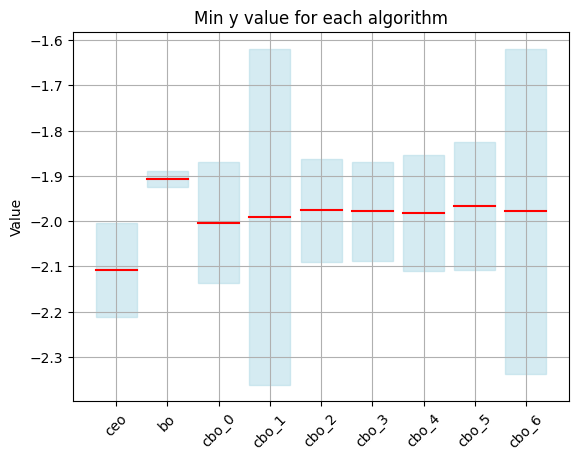

In [88]:
min_results = all_best(base_path=base_path, num_cbo_graphs=7)
print(min_results)
box_plots_mean(min_results, experiment="Min")

{'ceo': {'mean': 20.8, 'std': 15.860643114325473}, 'bo': {'mean': 30.1, 'std': 14.446106741956463}, 'cbo_0': {'mean': 23.1, 'std': 13.456968455042167}, 'cbo_1': {'mean': 29.6, 'std': 12.784365451597509}, 'cbo_2': {'mean': 23.1, 'std': 13.277424449041312}, 'cbo_3': {'mean': 24.4, 'std': 13.200000000000001}, 'cbo_4': {'mean': 26.3, 'std': 10.564563407921787}, 'cbo_5': {'mean': 19.4, 'std': 14.037093716293269}, 'cbo_6': {'mean': 17.5, 'std': 13.070960178961606}}


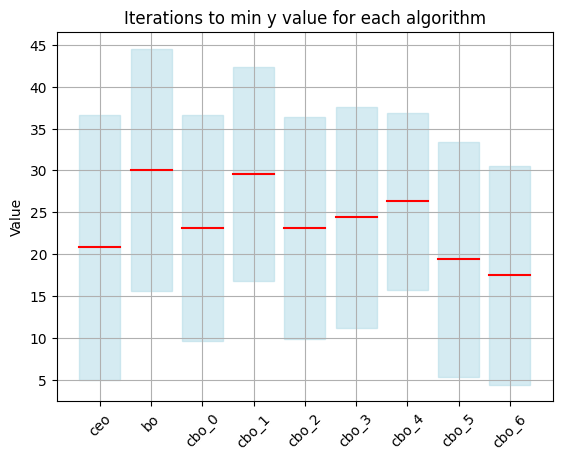

In [89]:
argmin_results = iterations_to_min(base_path=base_path, num_cbo_graphs=7)
print(argmin_results)
box_plots_mean(argmin_results, experiment="Iterations to min")

# Graph 6

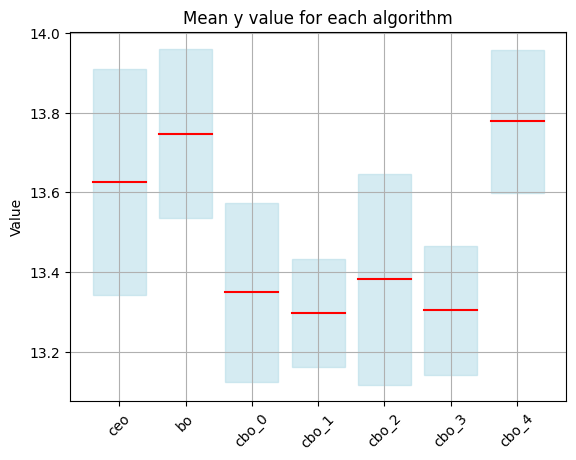

In [90]:
base_path = "Graph6"
# plot_everything(base_path=base_path, experiment="Best_Y", n_obs=10, num_cbo_graphs=7,save_file=False, plot_ceo=True, graph_idxs = [0, 4, 6])
mean_results = all_means(base_path=base_path, num_cbo_graphs=5)
box_plots_mean(mean_results, experiment="Mean")

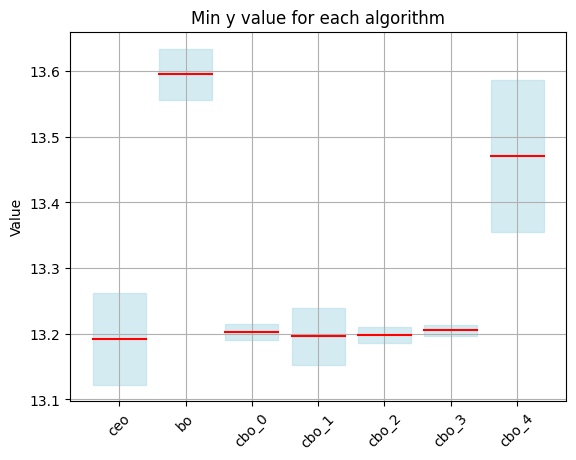

In [91]:
min_results = all_best(base_path=base_path, num_cbo_graphs=5)
box_plots_mean(min_results, experiment="Min")

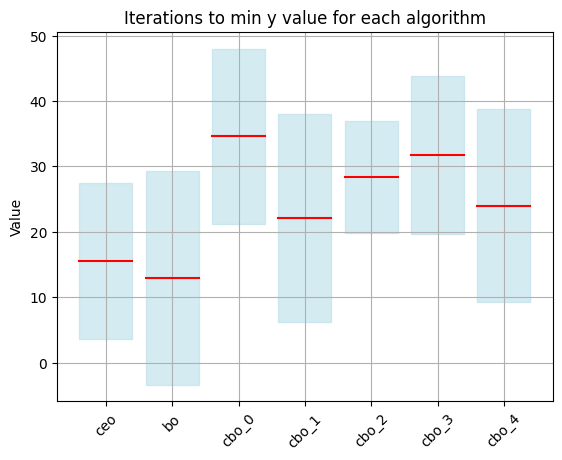

In [92]:
argmin_results = iterations_to_min(base_path=base_path, num_cbo_graphs=5)
box_plots_mean(argmin_results, experiment="Iterations to min")

In [93]:
argmin_results

{'ceo': {'mean': 15.6, 'std': 11.92644121270046},
 'bo': {'mean': 13.0, 'std': 16.358484037342826},
 'cbo_0': {'mean': 34.6, 'std': 13.417898494175606},
 'cbo_1': {'mean': 22.1, 'std': 15.889933920567449},
 'cbo_2': {'mean': 28.4, 'std': 8.581375181169975},
 'cbo_3': {'mean': 31.7, 'std': 12.050311199301039},
 'cbo_4': {'mean': 24.0, 'std': 14.717336715588184}}